In [ ]:
import numpy as np
import pandas as pd

In [ ]:
#Temel Tablolar
patients = pd.read_csv("PATIENTS.csv", parse_dates = ['dob', 'dod', 'dod_hosp', 'dod_ssn'])
admissions = pd.read_csv("ADMISSIONS.csv", parse_dates = ['admittime', 'dischtime', 'deathtime', 'edregtime', 'edouttime'])
icustays = pd.read_csv("ICUSTAYS.csv", parse_dates = ['intime', 'outtime'])

#Hedef Değişkeni
diagnoses_icd = pd.read_csv("DIAGNOSES_ICD.csv")

#Özellik (Feature) Tabloları
chartevents = pd.read_csv("CHARTEVENTS.csv")
labevents = pd.read_csv("LABEVENTS.csv")

#Sözlük (Dictionary) Tabloları
d_icd_diagnoses = pd.read_csv("D_ICD_DIAGNOSES.csv")
d_items = pd.read_csv("D_ITEMS.csv")
d_labitems = pd.read_csv("D_LABITEMS.csv")

/tmp/ipython-input-11-69767842.py:10: DtypeWarning: Columns (8,13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  chartevents = pd.read_csv("CHARTEVENTS.csv")


In [ ]:
patients_clean = patients[['subject_id', 'gender', 'dob', 'dod']]
admissions_clean = admissions[['subject_id', 'hadm_id', 'admittime', 'admission_type', 'ethnicity', 'diagnosis']]
icustays_clean = icustays[['subject_id', 'hadm_id', 'icustay_id', 'intime', 'outtime', 'los']]
diagnoses_icd_clean = diagnoses_icd[['hadm_id', 'icd9_code']]

In [ ]:
cohort = pd.merge(icustays_clean, patients_clean, on='subject_id', how='inner')
cohort = pd.merge(cohort, admissions_clean, on=['subject_id', 'hadm_id'], how='inner')

In [ ]:
# yıl farkını hesaplayarak kimlerin "sahte yaşlı" olduğunu bulalım.
potential_age = cohort['intime'].dt.year - cohort['dob'].dt.year

# "Sahte yaşlı" olmayan hastaların (potential_age < 150) indekslerini belirle.
normal_age_indices = cohort[potential_age < 150].index
cohort.loc[normal_age_indices, 'age'] = (cohort.loc[normal_age_indices, 'intime'] - cohort.loc[normal_age_indices, 'dob']).dt.days / 365.25

cohort['age'] = cohort['age'].fillna(90)
cohort['age'] = cohort['age'].astype(int)

print("İlk 5 hastanın yaşı:")
print(cohort[['subject_id', 'age']].head())
print("\nYaş dağılımı:")
print(cohort['age'].describe())

İlk 5 hastanın yaşı:
   subject_id  age
0       10006   70
1       10011   36
2       10013   87
3       10017   73
4       10019   48

Yaş dağılımı:
count    136.000000
mean      70.382353
std       16.189644
min       17.000000
25%       63.000000
50%       74.000000
75%       83.000000
max       90.000000
Name: age, dtype: float64


In [ ]:
# Sepsis ile ilişkili ICD9 kodları
sepsis_codes = ['99591', '99592', '78552']

diagnoses_icd_clean['is_sepsis'] = diagnoses_icd_clean['icd9_code'].isin(sepsis_codes).astype(int)

# Her bir HADM_ID için sepsis teşhisi olup olmadığını gruplayalım
sepsis_labels = diagnoses_icd_clean.groupby('hadm_id')['is_sepsis'].max().reset_index()

cohort = pd.merge(cohort, sepsis_labels, on='hadm_id', how='left')

# NaN değerler için
cohort['is_sepsis'] = cohort['is_sepsis'].fillna(0).astype(int)

/tmp/ipython-input-15-2639128807.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diagnoses_icd_clean['is_sepsis'] = diagnoses_icd_clean['icd9_code'].isin(sepsis_codes).astype(int)


# Özellik Verileri

In [ ]:
d_items = pd.read_csv('D_ITEMS.csv')
d_labitems = pd.read_csv('D_LABITEMS.csv')

vitals_map = {
    211: 'HeartRate',
    220045: 'HeartRate',
    618: 'RespRate',
    220210: 'RespRate',
    646: 'SpO2',
    220277: 'SpO2',
    51: 'SysBP',      # Arteryel Sistolik Kan Basıncı
    220050: 'SysBP',
    8368: 'DiaBP',    # Arteryel Diyastolik Kan Basıncı
    220051: 'DiaBP',
    678: 'TemperatureC', # Santigrat
    223761: 'TemperatureF' # Fahrenhayt (Santigrata çevrilmeli)
}

labs_map = {
    50912: 'Creatinine',
    51006: 'BUN',          # Blood Urea Nitrogen
    51301: 'WBC',          # White Blood Cell Count
    51265: 'Platelets',
    50813: 'Lactate',
    50882: 'Bicarbonate'
}

In [ ]:
chartevents = pd.read_csv('CHARTEVENTS.csv', parse_dates=['charttime'])
labevents = pd.read_csv('LABEVENTS.csv', parse_dates=['charttime'])

vitals = chartevents[chartevents['itemid'].isin(vitals_map.keys())]
labs = labevents[labevents['itemid'].isin(labs_map.keys())]

vitals_clean = vitals[['icustay_id', 'charttime', 'itemid', 'valuenum']]
vitals_clean['label'] = vitals_clean['itemid'].map(vitals_map)

labs_clean = labs[['hadm_id', 'charttime', 'itemid', 'valuenum']]

labs_clean = pd.merge(labs_clean, cohort[['hadm_id', 'icustay_id']], on='hadm_id', how='inner')
labs_clean['label'] = labs_clean['itemid'].map(labs_map)

features = pd.concat([
    vitals_clean[['icustay_id', 'charttime', 'label', 'valuenum']],
    labs_clean[['icustay_id', 'charttime', 'label', 'valuenum']]
])

/tmp/ipython-input-17-1318724709.py:1: DtypeWarning: Columns (8,13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  chartevents = pd.read_csv('CHARTEVENTS.csv', parse_dates=['charttime'])
/tmp/ipython-input-17-1318724709.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vitals_clean['label'] = vitals_clean['itemid'].map(vitals_map)


# Zaman Serisi Verileri

In [ ]:
# Kohorttan YBÜ giriş zamanını (INTIME)
features = pd.merge(features, cohort[['icustay_id', 'intime']], on='icustay_id', how='left')

# Ölçümün YBÜ'ye girişten kaç saat sonra yapıldığı
features['hours_since_admit'] = (features['charttime'] - features['intime']).dt.total_seconds() / 3600

# İlk 24 saati filtreleme
features_first_24h = features[(features['hours_since_admit'] >= 0) & (features['hours_since_admit'] <= 24)]

final_features = features_first_24h.pivot_table(
    index='icustay_id',
    columns='label',
    values='valuenum',
    aggfunc='mean' # Ortalama yerine 'max', 'min', 'std' (standart sapma) da kullanılabilir
).reset_index()

final_dataset = pd.merge(cohort[['icustay_id', 'age', 'gender', 'ethnicity', 'admission_type', 'is_sepsis']],
                         final_features,
                         on='icustay_id',
                         how='inner')

In [ ]:
final_dataset

,icustay_id,age,gender,ethnicity,admission_type,is_sepsis,BUN,Bicarbonate,Creatinine,DiaBP,HeartRate,Lactate,Platelets,RespRate,SpO2,SysBP,TemperatureC,TemperatureF,WBC
0,206504,70,F,BLACK/AFRICAN AMERICAN,EMERGENCY,1,11.00,31.00,3.500000,NaN,86.062500,1.300000,106.000000,28.875000,98.533333,NaN,98.571429,NaN,4.60
1,232110,36,F,UNKNOWN/NOT SPECIFIED,EMERGENCY,0,3.00,23.00,0.700000,NaN,86.958333,NaN,299.000000,18.833333,98.913043,NaN,98.028571,NaN,10.60
2,264446,87,F,UNKNOWN/NOT SPECIFIED,EMERGENCY,0,32.00,29.00,1.700000,NaN,98.725000,NaN,216.500000,23.900000,93.384615,112.605263,NaN,NaN,15.00
3,204881,73,F,WHITE,EMERGENCY,0,3.00,29.00,0.300000,NaN,95.227273,NaN,202.000000,25.904762,92.823529,NaN,96.125000,NaN,15.80
4,228977,48,M,WHITE,EMERGENCY,1,39.25,13.50,5.333333,NaN,83.547619,16.812500,57.333333,31.350000,88.937500,83.833333,96.079999,NaN,5.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130,286428,54,M,WHITE,EMERGENCY,0,NaN,NaN,NaN,NaN,113.000000,NaN,166.000000,21.913043,97.125000,NaN,NaN,98.866667,12.30
131,217724,90,M,WHITE,EMERGENCY,1,21.00,19.00,0.900000,61.260870,73.437500,2.675000,80.000000,25.939394,86.343750,101.000000,NaN,99.233333,17.10
132,239396,45,F,BLACK/AFRICAN AMERICAN,EMERGENCY,1,49.25,20.00,3.975000,52.600000,95.916667,2.266667,70.000000,32.638889,96.805556,96.714286,NaN,97.912500,10.10
133,238186,73,M,WHITE,EMERGENCY,0,23.00,26.50,1.450000,NaN,56.413793,NaN,197.000000,17.137931,97.700000,NaN,NaN,96.920000,9.30


In [ ]:
final_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135 entries, 0 to 134
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   icustay_id      135 non-null    int64  
 1   age             135 non-null    int64  
 2   gender          135 non-null    object 
 3   ethnicity       135 non-null    object 
 4   admission_type  135 non-null    object 
 5   is_sepsis       135 non-null    int64  
 6   BUN             131 non-null    float64
 7   Bicarbonate     132 non-null    float64
 8   Creatinine      132 non-null    float64
 9   DiaBP           16 non-null     float64
 10  HeartRate       132 non-null    float64
 11  Lactate         62 non-null     float64
 12  Platelets       131 non-null    float64
 13  RespRate        132 non-null    float64
 14  SpO2            132 non-null    float64
 15  SysBP           39 non-null     float64
 16  TemperatureC    54 non-null     float64
 17  TemperatureF    75 non-null     flo

In [ ]:
final_dataset.isnull().sum()

,0
icustay_id,0
age,0
gender,0
ethnicity,0
admission_type,0
is_sepsis,0
BUN,4
Bicarbonate,3
Creatinine,3
DiaBP,119


In [ ]:
# Fahrenhayt'tan Santigrat'a çevirme
temp_f_in_c = (final_dataset['TemperatureF'] - 32) * 5/9
final_dataset['Temperature'] = np.where(final_dataset['TemperatureC'].isnull(),
                                        temp_f_in_c,
                                        final_dataset['TemperatureC'])

final_dataset = final_dataset.drop(columns=['TemperatureC', 'TemperatureF'])

print("Sıcaklık sütunları birleştirildikten sonra eksik veri durumu:")
print(final_dataset.isnull().sum())

Sıcaklık sütunları birleştirildikten sonra eksik veri durumu:
icustay_id          0
age                 0
gender              0
ethnicity           0
admission_type      0
is_sepsis           0
BUN                 4
Bicarbonate         3
Creatinine          3
DiaBP             119
HeartRate           3
Lactate            73
Platelets           4
RespRate            3
SpO2                3
SysBP              96
WBC                 4
Temperature         6
dtype: int64


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

X = final_dataset.drop(columns=['is_sepsis', 'icustay_id'])
y = final_dataset['is_sepsis']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

numerical_cols = X_train.select_dtypes(include=np.number).columns.tolist()
categorical_cols = X_train.select_dtypes(exclude=np.number).columns.tolist()

imputer = SimpleImputer(strategy='median')

X_train[numerical_cols] = imputer.fit_transform(X_train[numerical_cols])

X_test[numerical_cols] = imputer.transform(X_test[numerical_cols])

print("\nEğitim seti eksik veri kontrolü:")
print(X_train.isnull().sum())


Eğitim seti eksik veri kontrolü:
age               0
gender            0
ethnicity         0
admission_type    0
BUN               0
Bicarbonate       0
Creatinine        0
DiaBP             0
HeartRate         0
Lactate           0
Platelets         0
RespRate          0
SpO2              0
SysBP             0
WBC               0
Temperature       0
dtype: int64


In [ ]:
X_train = pd.get_dummies(X_train, columns=categorical_cols, drop_first=True)
X_test = pd.get_dummies(X_test, columns=categorical_cols, drop_first=True)

train_cols = X_train.columns
test_cols = X_test.columns

missing_in_test = set(train_cols) - set(test_cols)
for c in missing_in_test:
    X_test[c] = 0

missing_in_train = set(test_cols) - set(train_cols)
for c in missing_in_train:
    X_train[c] = 0

X_test = X_test[train_cols] # Sütun sıralarını aynı yap

print("\nModel için hazır eğitim verisinin ilk 5 satırı:")
print(X_train.head())


Model için hazır eğitim verisinin ilk 5 satırı:
      age        BUN  Bicarbonate  Creatinine      DiaBP  HeartRate  Lactate  \
8    88.0  38.000000    25.000000    1.700000  54.686636  94.500000     1.55   
98   43.0  52.333333    17.333333    2.233333  54.686636  96.166667     1.55   
81   62.0  13.428571    16.142857    0.514286  54.516129  90.140625     7.00   
133  73.0  23.000000    26.500000    1.450000  54.686636  56.413793     1.55   
38   72.0  24.000000    21.000000    0.500000  54.686636  96.521739     1.55   

      Platelets   RespRate       SpO2  ...  ethnicity_ASIAN  \
8    129.000000  21.636364  97.147059  ...            False   
98    96.666667  15.333333  99.875000  ...            False   
81   192.875000  17.618182  96.470588  ...            False   
133  197.000000  17.137931  97.700000  ...            False   
38   186.000000  16.782609  96.826087  ...            False   

     ethnicity_BLACK/AFRICAN AMERICAN  ethnicity_HISPANIC OR LATINO  \
8                   

# Model

In [ ]:
numerical_cols = X_train.select_dtypes(include=np.number).columns.tolist()
categorical_cols = X_train.select_dtypes(exclude=np.number).columns.tolist()

X_train_encoded = pd.get_dummies(X_train, columns=categorical_cols, drop_first=True)
X_test_encoded = pd.get_dummies(X_test, columns=categorical_cols, drop_first=True)

final_train_cols = X_train_encoded.columns
X_test_aligned = X_test_encoded.reindex(columns=final_train_cols, fill_value=0)

X_train = X_train_encoded
X_test = X_test_aligned

print("Eğitim seti sütun sayısı:", len(X_train.columns))
print("Test seti sütun sayısı:", len(X_test.columns))
print("Sütunlar aynı mı?", X_train.columns.equals(X_test.columns))

Eğitim seti sütun sayısı: 24
Test seti sütun sayısı: 24
Sütunlar aynı mı? True


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

X_test_scaled = scaler.transform(X_test)

print("\nÖlçeklendirme başarıyla tamamlandı!")


Ölçeklendirme başarıyla tamamlandı!


# Model Seçimi (Lojisitk Regresyon)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

log_reg = LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000)
log_reg.fit(X_train_scaled, y_train)

y_pred_log_reg = log_reg.predict(X_test_scaled)
y_pred_proba_log_reg = log_reg.predict_proba(X_test_scaled)[:, 1]

In [ ]:
print("--- Lojistik Regresyon Sonuçları ---")
print(classification_report(y_test, y_pred_log_reg))
auc_log_reg = roc_auc_score(y_test, y_pred_proba_log_reg)
print(f"Lojistik Regresyon AUC Skoru: {auc_log_reg:.4f}")

--- Lojistik Regresyon Sonuçları ---
              precision    recall  f1-score   support

           0       0.76      0.84      0.80        19
           1       0.50      0.38      0.43         8

    accuracy                           0.70        27
   macro avg       0.63      0.61      0.61        27
weighted avg       0.68      0.70      0.69        27

Lojistik Regresyon AUC Skoru: 0.7632


# Model Seçimi (Random Forest)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_clf.fit(X_train_scaled, y_train)

y_pred_rf = rf_clf.predict(X_test_scaled)
y_pred_proba_rf = rf_clf.predict_proba(X_test_scaled)[:, 1]

In [ ]:
print("\n--- Random Forest Sonuçları ---")
print(classification_report(y_test, y_pred_rf))
auc_rf = roc_auc_score(y_test, y_pred_proba_rf)
print(f"Random Forest AUC Skoru: {auc_rf:.4f}")


--- Random Forest Sonuçları ---
              precision    recall  f1-score   support

           0       0.75      0.95      0.84        19
           1       0.67      0.25      0.36         8

    accuracy                           0.74        27
   macro avg       0.71      0.60      0.60        27
weighted avg       0.73      0.74      0.70        27

Random Forest AUC Skoru: 0.7105


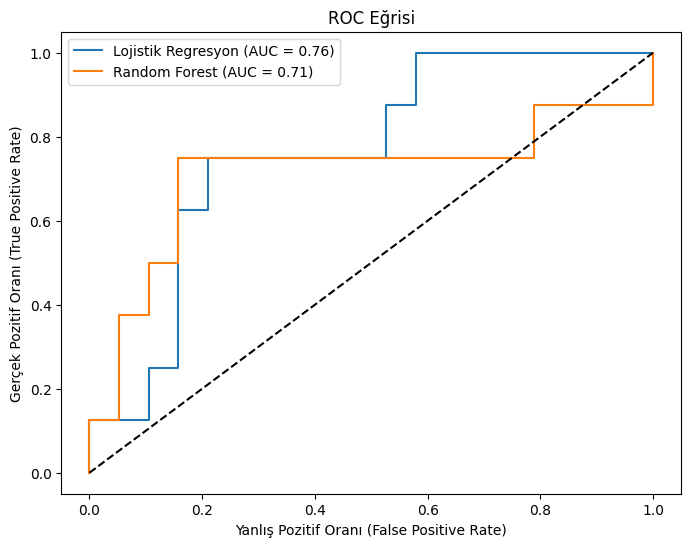

In [ ]:
fpr_log, tpr_log, _ = roc_curve(y_test, y_pred_proba_log_reg)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)

plt.figure(figsize=(8, 6))
plt.plot(fpr_log, tpr_log, label=f'Lojistik Regresyon (AUC = {auc_log_reg:.2f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.2f})')
plt.plot([0, 1], [0, 1], 'k--') # rastgele tahmin çizgisi (0.5)
plt.xlabel('Yanlış Pozitif Oranı (False Positive Rate)')
plt.ylabel('Gerçek Pozitif Oranı (True Positive Rate)')
plt.title('ROC Eğrisi')
plt.legend()
plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV

rf_clf = RandomForestClassifier(random_state=42, class_weight='balanced')

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

grid_search = GridSearchCV(estimator=rf_clf, param_grid=param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=2)
grid_search.fit(X_train_scaled, y_train)

print("En iyi parametreler:", grid_search.best_params_)
print("En iyi AUC skoru (Çapraz Doğrulama ile):", grid_search.best_score_)

best_rf_model = grid_search.best_estimator_

y_pred_best_rf = best_rf_model.predict(X_test_scaled)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
En iyi parametreler: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'n_estimators': 200}
En iyi AUC skoru (Çapraz Doğrulama ile): 0.8861111111111111


In [ ]:
import xgboost as xgb

scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

xgb_clf = xgb.XGBClassifier(
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=scale_pos_weight, # Dengesizliğe karşı hassaslaştırır
    random_state=42
)

xgb_clf.fit(X_train_scaled, y_train)

y_pred_xgb = xgb_clf.predict(X_test_scaled)
print("\n--- XGBoost Sonuçları ---")
print(classification_report(y_test, y_pred_xgb))


--- XGBoost Sonuçları ---
              precision    recall  f1-score   support

           0       0.83      0.79      0.81        19
           1       0.56      0.62      0.59         8

    accuracy                           0.74        27
   macro avg       0.69      0.71      0.70        27
weighted avg       0.75      0.74      0.74        27



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:30:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


# Veriyi Zenginleştirme

In [ ]:
final_features = features_first_24h.pivot_table(
    index='icustay_id',
    columns='label',
    values='valuenum',
    aggfunc=['mean', 'std', 'min', 'max'] # Birden fazla fonksiyonu liste olarak verin
).reset_index()

final_features.columns = ['_'.join(col).strip() for col in final_features.columns.values]

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(random_state=42, class_weight='balanced')) # class_weight'ı yine de tutmak faydalı olabilir
])

pipeline.fit(X_train, y_train)

y_pred_pipeline = pipeline.predict(X_test)
print(classification_report(y_test, y_pred_pipeline))

              precision    recall  f1-score   support

           0       0.81      0.89      0.85        19
           1       0.67      0.50      0.57         8

    accuracy                           0.78        27
   macro avg       0.74      0.70      0.71        27
weighted avg       0.77      0.78      0.77        27



# OUTPUTEVENTS Veri Seti Eklenmesi

In [ ]:
import pandas as pd
import numpy as np

try:
    outputevents = pd.read_csv('OUTPUTEVENTS.csv', parse_dates=['charttime'])
    d_items = pd.read_csv('D_ITEMS.csv')
except FileNotFoundError:
    print("Lütfen OUTPUTEVENTS.csv ve D_ITEMS.csv dosyalarının doğru klasörde olduğundan emin olun.")
    # Bu blok, dosya bulunamazsa programın çökmesini engeller.

urine_itemids = [
    40055,  # Urine Out Foley
    43175,  # Urine ."
    40069,  # Urine Out Void
    40094,  # Urine Out Condom Cath
    40715,  # Urine Out Suprapubic
    40473,  # Urine Out Ileo-conduit
    40085,  # Urine Out Incontinent
    40057,  # Urine Out Rt Nephrostomy
    40056,  # Urine Out Lt Nephrostomy
    40405,  # Urine Out Other
    40428,  # Urine Out Straight Cath
    40086,  # Urine Out Urostomy
    226559, # Urine Output
    226560, # Urine Output C
    226561, # Urine Output D
    227488, # Urine Output O
    226563, # Urine Output R
]

urine_output = outputevents[outputevents['itemid'].isin(urine_itemids)]
urine_output = urine_output[['icustay_id', 'charttime', 'value']]
urine_output.columns = ['icustay_id', 'charttime', 'value']

urine_output = pd.merge(urine_output, cohort[['icustay_id', 'intime']], on='icustay_id', how='left')

urine_output['hours_since_admit'] = (urine_output['charttime'] - urine_output['intime']).dt.total_seconds() / 3600

urine_first_24h = urine_output[
    (urine_output['hours_since_admit'] >= 0) & (urine_output['hours_since_admit'] <= 24)
]

urine_total_24h = urine_first_24h.groupby('icustay_id')['value'].sum().reset_index()
urine_total_24h = urine_total_24h.rename(columns={'value': 'urine_output_24h'})

print("Önceki veri seti boyutu:", final_dataset.shape)
print("Önceki sütunlar:", final_dataset.columns.tolist())


final_dataset = pd.merge(final_dataset, urine_total_24h, on='icustay_id', how='left')
final_dataset['urine_output_24h'] = final_dataset['urine_output_24h'].fillna(0)

print("\nSonraki veri seti boyutu:", final_dataset.shape)
print("Yeni eklenen sütunla sütunlar:", final_dataset.columns.tolist())
print("\n'urine_output_24h' sütunundaki eksik veri sayısı:", final_dataset['urine_output_24h'].isnull().sum())
print("\nİşlem tamamlandı! 'urine_output_24h' özelliği eklendi.")

Önceki veri seti boyutu: (135, 18)
Önceki sütunlar: ['icustay_id', 'age', 'gender', 'ethnicity', 'admission_type', 'is_sepsis', 'BUN', 'Bicarbonate', 'Creatinine', 'DiaBP', 'HeartRate', 'Lactate', 'Platelets', 'RespRate', 'SpO2', 'SysBP', 'WBC', 'Temperature']

Sonraki veri seti boyutu: (135, 19)
Yeni eklenen sütunla sütunlar: ['icustay_id', 'age', 'gender', 'ethnicity', 'admission_type', 'is_sepsis', 'BUN', 'Bicarbonate', 'Creatinine', 'DiaBP', 'HeartRate', 'Lactate', 'Platelets', 'RespRate', 'SpO2', 'SysBP', 'WBC', 'Temperature', 'urine_output_24h']

'urine_output_24h' sütunundaki eksik veri sayısı: 0

İşlem tamamlandı! 'urine_output_24h' özelliği eklendi.


In [ ]:
final_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135 entries, 0 to 134
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   icustay_id        135 non-null    int64  
 1   age               135 non-null    int64  
 2   gender            135 non-null    object 
 3   ethnicity         135 non-null    object 
 4   admission_type    135 non-null    object 
 5   is_sepsis         135 non-null    int64  
 6   BUN               131 non-null    float64
 7   Bicarbonate       132 non-null    float64
 8   Creatinine        132 non-null    float64
 9   DiaBP             16 non-null     float64
 10  HeartRate         132 non-null    float64
 11  Lactate           62 non-null     float64
 12  Platelets         131 non-null    float64
 13  RespRate          132 non-null    float64
 14  SpO2              132 non-null    float64
 15  SysBP             39 non-null     float64
 16  WBC               131 non-null    float64
 1

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

X = final_dataset.drop(columns=['is_sepsis', 'icustay_id'])
y = final_dataset['is_sepsis']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

numerical_cols = X_train.select_dtypes(include=np.number).columns.tolist()
categorical_cols = X_train.select_dtypes(exclude=np.number).columns.tolist()

imputer = SimpleImputer(strategy='median')

X_train[numerical_cols] = imputer.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = imputer.transform(X_test[numerical_cols])

print("\nEğitim seti eksik veri kontrolü:")
print(X_train.isnull().sum())


Eğitim seti eksik veri kontrolü:
age                 0
gender              0
ethnicity           0
admission_type      0
BUN                 0
Bicarbonate         0
Creatinine          0
DiaBP               0
HeartRate           0
Lactate             0
Platelets           0
RespRate            0
SpO2                0
SysBP               0
WBC                 0
Temperature         0
urine_output_24h    0
dtype: int64


In [ ]:
X_train = pd.get_dummies(X_train, columns=categorical_cols, drop_first=True)
X_test = pd.get_dummies(X_test, columns=categorical_cols, drop_first=True)

train_cols = X_train.columns
test_cols = X_test.columns

missing_in_test = set(train_cols) - set(test_cols)
for c in missing_in_test:
    X_test[c] = 0

missing_in_train = set(test_cols) - set(train_cols)
for c in missing_in_train:
    X_train[c] = 0

X_test = X_test[train_cols] # Sütun sıralarını aynı yap

print("\nModel için hazır eğitim verisinin ilk 5 satırı:")
print(X_train.head())


Model için hazır eğitim verisinin ilk 5 satırı:
      age        BUN  Bicarbonate  Creatinine      DiaBP  HeartRate  Lactate  \
8    88.0  38.000000    25.000000    1.700000  54.686636  94.500000     1.55   
98   43.0  52.333333    17.333333    2.233333  54.686636  96.166667     1.55   
81   62.0  13.428571    16.142857    0.514286  54.516129  90.140625     7.00   
133  73.0  23.000000    26.500000    1.450000  54.686636  56.413793     1.55   
38   72.0  24.000000    21.000000    0.500000  54.686636  96.521739     1.55   

      Platelets   RespRate       SpO2  ...  ethnicity_ASIAN  \
8    129.000000  21.636364  97.147059  ...            False   
98    96.666667  15.333333  99.875000  ...            False   
81   192.875000  17.618182  96.470588  ...            False   
133  197.000000  17.137931  97.700000  ...            False   
38   186.000000  16.782609  96.826087  ...            False   

     ethnicity_BLACK/AFRICAN AMERICAN  ethnicity_HISPANIC OR LATINO  \
8                   

In [ ]:
numerical_cols = X_train.select_dtypes(include=np.number).columns.tolist()
categorical_cols = X_train.select_dtypes(exclude=np.number).columns.tolist()


X_train_encoded = pd.get_dummies(X_train, columns=categorical_cols, drop_first=True)
X_test_encoded = pd.get_dummies(X_test, columns=categorical_cols, drop_first=True)

final_train_cols = X_train_encoded.columns
X_test_aligned = X_test_encoded.reindex(columns=final_train_cols, fill_value=0)

X_train = X_train_encoded
X_test = X_test_aligned

print("Eğitim seti sütun sayısı:", len(X_train.columns))
print("Test seti sütun sayısı:", len(X_test.columns))
print("Sütunlar aynı mı?", X_train.columns.equals(X_test.columns))

Eğitim seti sütun sayısı: 25
Test seti sütun sayısı: 25
Sütunlar aynı mı? True


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# LOJİSTİK

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

log_reg = LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000)
log_reg.fit(X_train_scaled, y_train)

y_pred_log_reg = log_reg.predict(X_test_scaled)
y_pred_proba_log_reg = log_reg.predict_proba(X_test_scaled)[:, 1]

In [ ]:
print("--- Lojistik Regresyon Sonuçları ---")
print(classification_report(y_test, y_pred_log_reg))
auc_log_reg = roc_auc_score(y_test, y_pred_proba_log_reg)
print(f"Lojistik Regresyon AUC Skoru: {auc_log_reg:.4f}")

--- Lojistik Regresyon Sonuçları ---
              precision    recall  f1-score   support

           0       0.76      0.84      0.80        19
           1       0.50      0.38      0.43         8

    accuracy                           0.70        27
   macro avg       0.63      0.61      0.61        27
weighted avg       0.68      0.70      0.69        27

Lojistik Regresyon AUC Skoru: 0.7697


# RANDOM FOREST

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_clf.fit(X_train_scaled, y_train)

y_pred_rf = rf_clf.predict(X_test_scaled)
y_pred_proba_rf = rf_clf.predict_proba(X_test_scaled)[:, 1]

In [ ]:
print("\n--- Random Forest Sonuçları ---")
print(classification_report(y_test, y_pred_rf))
auc_rf = roc_auc_score(y_test, y_pred_proba_rf)
print(f"Random Forest AUC Skoru: {auc_rf:.4f}")


--- Random Forest Sonuçları ---
              precision    recall  f1-score   support

           0       0.72      0.95      0.82        19
           1       0.50      0.12      0.20         8

    accuracy                           0.70        27
   macro avg       0.61      0.54      0.51        27
weighted avg       0.65      0.70      0.64        27

Random Forest AUC Skoru: 0.6941


In [ ]:
from sklearn.model_selection import GridSearchCV

rf_clf = RandomForestClassifier(random_state=42, class_weight='balanced')

param_grid = {
    'n_estimators': [100, 200, 300],         # Ağaç sayısı
    'max_depth': [10, 20, None],             # Ağaçların maksimum derinliği
    'min_samples_leaf': [1, 2, 4],           # Bir yaprakta olması gereken minimum örnek sayısı
    'max_features': ['sqrt', 'log2'] # Her bir ağaç için kullanılacak özellik sayısı
}


grid_search = GridSearchCV(estimator=rf_clf, param_grid=param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=2)
grid_search.fit(X_train_scaled, y_train)

print("En iyi parametreler:", grid_search.best_params_)
print("En iyi AUC skoru (Çapraz Doğrulama ile):", grid_search.best_score_)

best_rf_model = grid_search.best_estimator_

y_pred_best_rf = best_rf_model.predict(X_test_scaled)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
En iyi parametreler: {'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 4, 'n_estimators': 200}
En iyi AUC skoru (Çapraz Doğrulama ile): 0.8879166666666667


In [ ]:
import xgboost as xgb

scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

xgb_clf = xgb.XGBClassifier(
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=scale_pos_weight, # Dengesizliğe karşı hassaslaştırır
    random_state=42
)

xgb_clf.fit(X_train_scaled, y_train)

y_pred_xgb = xgb_clf.predict(X_test_scaled)
print("\n--- XGBoost Sonuçları ---")
print(classification_report(y_test, y_pred_xgb))


--- XGBoost Sonuçları ---
              precision    recall  f1-score   support

           0       0.84      0.84      0.84        19
           1       0.62      0.62      0.62         8

    accuracy                           0.78        27
   macro avg       0.73      0.73      0.73        27
weighted avg       0.78      0.78      0.78        27



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:31:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [ ]:
final_features = features_first_24h.pivot_table(
    index='icustay_id',
    columns='label',
    values='valuenum',
    aggfunc=['mean', 'std', 'min', 'max'] # Birden fazla fonksiyonu liste hali
).reset_index()

final_features.columns = ['_'.join(col).strip() for col in final_features.columns.values]

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(random_state=42, class_weight='balanced'))
])

pipeline.fit(X_train, y_train)
y_pred_pipeline = pipeline.predict(X_test)

print(classification_report(y_test, y_pred_pipeline))

              precision    recall  f1-score   support

           0       0.81      0.89      0.85        19
           1       0.67      0.50      0.57         8

    accuracy                           0.78        27
   macro avg       0.74      0.70      0.71        27
weighted avg       0.77      0.78      0.77        27



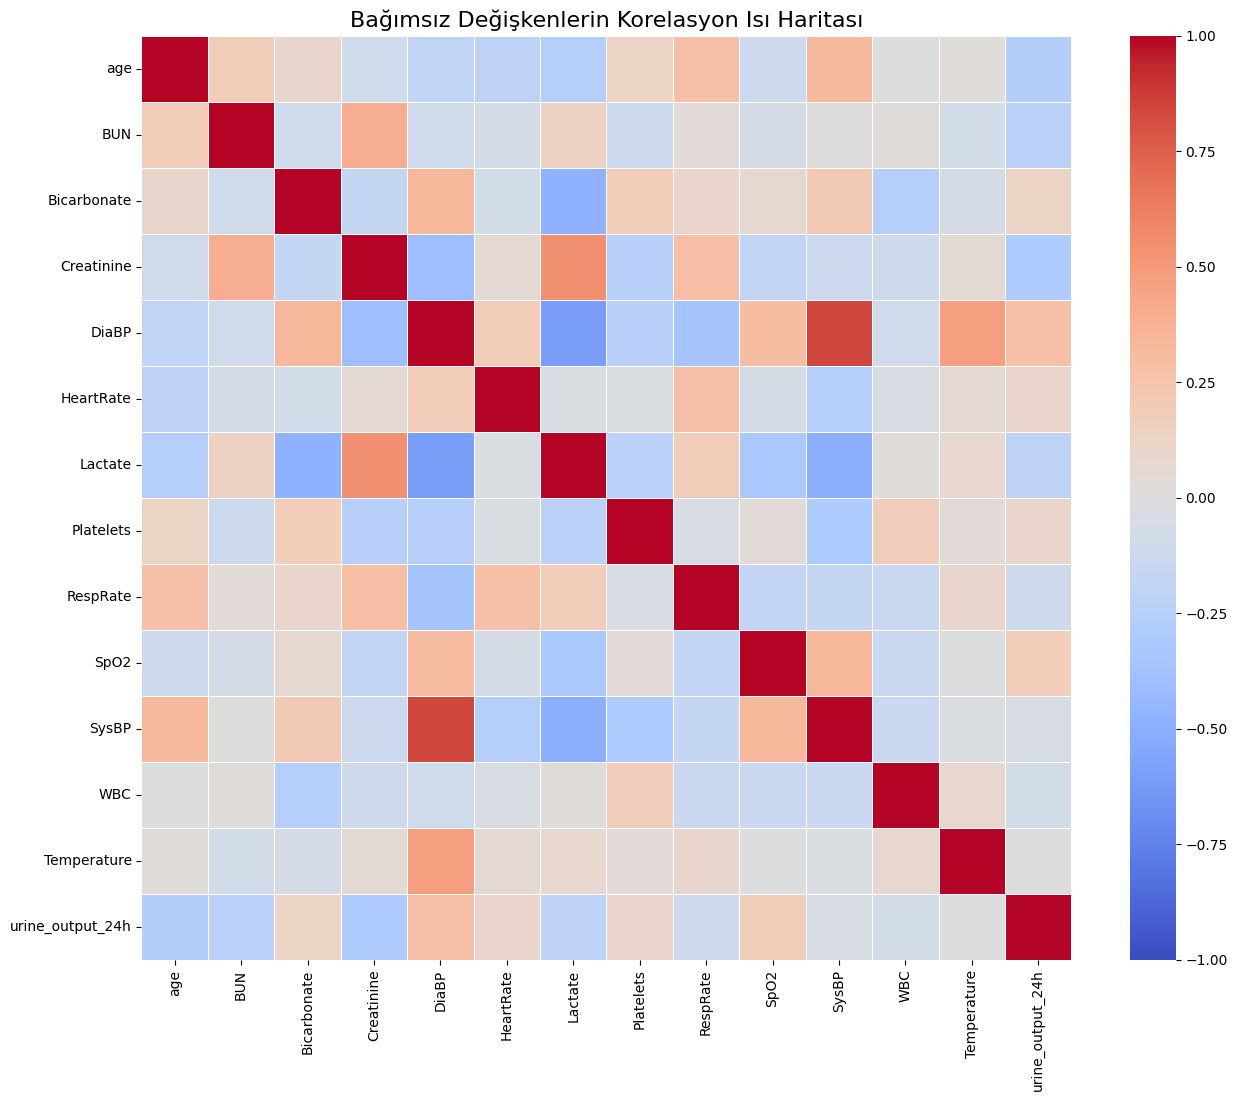

En Yüksek Korelasyona Sahip Değişken Çiftleri:
      Özellik 1    Özellik 2  Korelasyon
51        DiaBP        SysBP    0.837309
47        DiaBP      Lactate   -0.602466
38   Creatinine      Lactate    0.549535
66      Lactate        SysBP   -0.506048
28  Bicarbonate      Lactate   -0.487440
53        DiaBP  Temperature    0.470309
36   Creatinine        DiaBP   -0.401079
14          BUN   Creatinine    0.392813
49        DiaBP     RespRate   -0.352798
26  Bicarbonate        DiaBP    0.342591


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

numerical_features = final_dataset.select_dtypes(include=np.number)
if 'is_sepsis' in numerical_features.columns:
    numerical_features = numerical_features.drop(columns=['is_sepsis'])
if 'icustay_id' in numerical_features.columns:
    numerical_features = numerical_features.drop(columns=['icustay_id'])

correlation_matrix = numerical_features.corr()

# Isı haritası (Heatmap)
plt.figure(figsize=(15, 12))
sns.heatmap(
    correlation_matrix,
    annot=False,
    cmap='coolwarm',
    linewidths=.5,
    vmin=-1, vmax=1
)
plt.title('Bağımsız Değişkenlerin Korelasyon Isı Haritası', fontsize=16)
plt.show()

upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))

highly_correlated_pairs = upper_triangle.stack().reset_index()
highly_correlated_pairs.columns = ['Özellik 1', 'Özellik 2', 'Korelasyon']

strongest_correlations = highly_correlated_pairs.loc[highly_correlated_pairs['Korelasyon'].abs().sort_values(ascending=False).index]

print("En Yüksek Korelasyona Sahip Değişken Çiftleri:")
print(strongest_correlations.head(10))

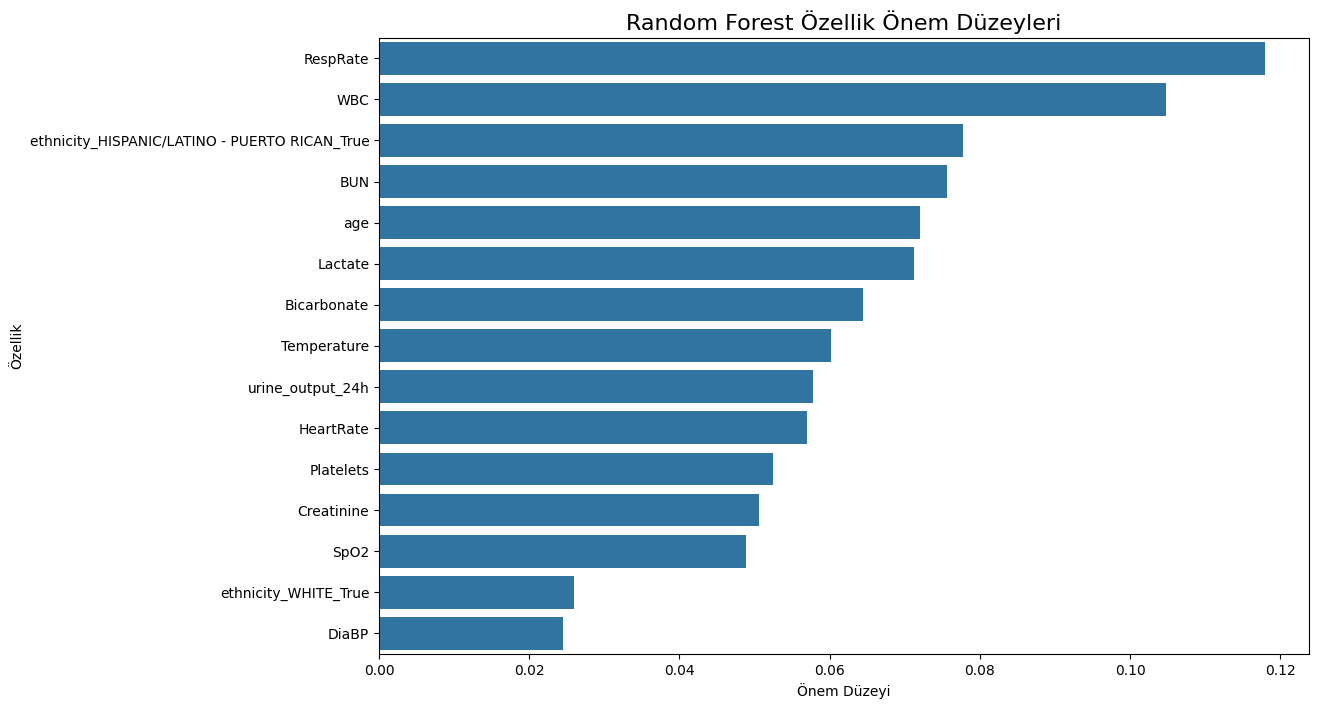


En Önemli Değişkenler:
                                          Özellik  Önem Düzeyi
8                                        RespRate     0.117929
11                                            WBC     0.104721
19  ethnicity_HISPANIC/LATINO - PUERTO RICAN_True     0.077795
1                                             BUN     0.075560
0                                             age     0.072006
6                                         Lactate     0.071214
2                                     Bicarbonate     0.064491
12                                    Temperature     0.060154
13                               urine_output_24h     0.057844
5                                       HeartRate     0.057021


In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_clf.fit(X_train_scaled, y_train)

importances = rf_clf.feature_importances_

feature_importance_df = pd.DataFrame({
    'Özellik': X_train.columns,
    'Önem Düzeyi': importances
})

feature_importance_df = feature_importance_df.sort_values(by='Önem Düzeyi', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Önem Düzeyi', y='Özellik', data=feature_importance_df.head(15))
plt.title('Random Forest Özellik Önem Düzeyleri', fontsize=16)
plt.xlabel('Önem Düzeyi')
plt.ylabel('Özellik')
plt.show()

print("\nEn Önemli Değişkenler:")
print(feature_importance_df.head(10))

In [ ]:
import statsmodels.api as sm

print("--- Statsmodels ile İstatistiksel Anlamlılık Testi ---")

X_train_encoded = pd.get_dummies(X_train, drop_first=True)

# Sabit Değerli Sütunları Bulma ve Çıkarma (Singular Matrix Hatası Çözümü)
constant_columns = X_train_encoded.columns[X_train_encoded.nunique() <= 1]

if len(constant_columns) > 0:
    print(f"\nVeri setinde sabit değerli (varyansı 0) sütunlar bulundu: {list(constant_columns)}")
    print("Bu sütunlar modelden çıkarılıyor...")
    X_train_final = X_train_encoded.drop(columns=constant_columns)
else:
    print("\nSabit değerli sütun bulunamadı. Veri seti bu açıdan temiz görünüyor.")
    X_train_final = X_train_encoded

X_train_final = X_train_final.astype(int)
X_train_with_const = sm.add_constant(X_train_final)
y_train_numeric = pd.to_numeric(y_train)

print("\nLojistik Regresyon modeli oluşturuluyor ve eğitiliyor...")
try:
    logit_model = sm.Logit(y_train_numeric, X_train_with_const)
    result = logit_model.fit(method='newton')

    print("\n--- Model Özeti ---")
    print(result.summary())

except Exception as e:
    print(f"\nModel eğitilirken bir hata oluştu: {e}")
    print("Veri setinizde hala çoklu doğrusallık sorunu olabilir. Korelasyon matrisini incelemeyi deneyin.")

--- Statsmodels ile İstatistiksel Anlamlılık Testi ---

Veri setinde sabit değerli (varyansı 0) sütunlar bulundu: ['ethnicity_UNABLE TO OBTAIN']
Bu sütunlar modelden çıkarılıyor...

Lojistik Regresyon modeli oluşturuluyor ve eğitiliyor...
         Current function value: 0.269710
         Iterations: 35

--- Model Özeti ---
                           Logit Regression Results                           
Dep. Variable:              is_sepsis   No. Observations:                  108
Model:                          Logit   Df Residuals:                       83
Method:                           MLE   Df Model:                           24
Date:                Wed, 16 Jul 2025   Pseudo R-squ.:                  0.5435
Time:                        10:31:32   Log-Likelihood:                -29.129
converged:                      False   LL-Null:                       -63.811
Covariance Type:            nonrobust   LLR p-value:                 2.728e-06
                                          

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


--- Pipeline Model Sonuçları ---
              precision    recall  f1-score   support

           0       0.81      0.89      0.85        19
           1       0.67      0.50      0.57         8

    accuracy                           0.78        27
   macro avg       0.74      0.70      0.71        27
weighted avg       0.77      0.78      0.77        27


--- Pipeline İçindeki Modelin Özellik Önem Düzeyleri ---


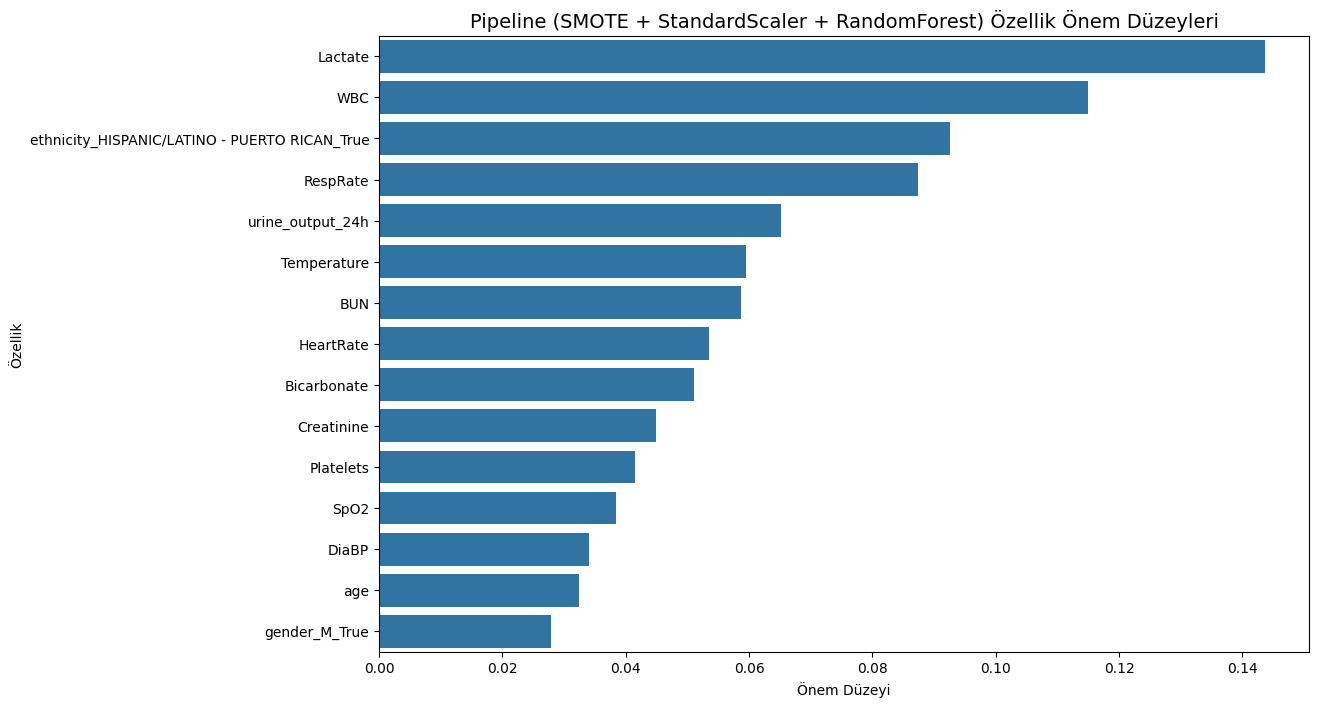


En Önemli Değişkenler (Pipeline'a Göre):
                                          Özellik  Önem Düzeyi
6                                         Lactate     0.143628
11                                            WBC     0.114926
19  ethnicity_HISPANIC/LATINO - PUERTO RICAN_True     0.092648
8                                        RespRate     0.087391
13                               urine_output_24h     0.065189
12                                    Temperature     0.059492
1                                             BUN     0.058765
5                                       HeartRate     0.053526
2                                     Bicarbonate     0.051004
3                                      Creatinine     0.044838


In [ ]:
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

X_train_encoded = pd.get_dummies(X_train, drop_first=True)
X_test_encoded = pd.get_dummies(X_test, drop_first=True)
X_test_encoded = X_test_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)

pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(random_state=42, class_weight='balanced'))
])

pipeline.fit(X_train_encoded, y_train)

y_pred_pipeline = pipeline.predict(X_test_encoded)
print("--- Pipeline Model Sonuçları ---")
print(classification_report(y_test, y_pred_pipeline))

print("\n--- Pipeline İçindeki Modelin Özellik Önem Düzeyleri ---")

trained_model = pipeline.named_steps['classifier']

importances = trained_model.feature_importances_
feature_names = X_train_encoded.columns
feature_importance_df = pd.DataFrame({
    'Özellik': feature_names,
    'Önem Düzeyi': importances
})

feature_importance_df = feature_importance_df.sort_values(by='Önem Düzeyi', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Önem Düzeyi', y='Özellik', data=feature_importance_df.head(15))
plt.title('Pipeline (SMOTE + StandardScaler + RandomForest) Özellik Önem Düzeyleri', fontsize=14)
plt.xlabel('Önem Düzeyi')
plt.ylabel('Özellik')
plt.show()

print("\nEn Önemli Değişkenler (Pipeline'a Göre):")
print(feature_importance_df.head(10))